In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
work_pth = '/content/drive/MyDrive/262B_final'
os.chdir(work_pth) # customize this line to your working directory

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
spx = pd.read_csv("etf_SPX.csv",parse_dates=["Date"])
tesla = pd.read_csv("stock_TSLA.csv",parse_dates=["Date"])

<ipython-input-10-5789ec85da0a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tesla = pd.read_csv("stock_TSLA.csv",parse_dates=["Date"])


In [11]:
print(spx.head(5))
print(tesla.head(5))

        Date  Close/Last     Open     High      Low
0 2025-04-08     4982.77  5193.57  5267.47  4910.42
1 2025-04-07     5062.25  4953.79  5246.57  4835.04
2 2025-04-04     5074.08  5292.14  5292.14  5069.90
3 2025-04-03     5396.52  5492.74  5499.53  5390.83
4 2025-04-02     5670.97  5580.76  5695.31  5571.48
        Date    Open    High     Low  Close   Adj Close        Volume
0 2025-04-10  260.03  262.49  252.80  255.95      255.95   39,492,622
1 2025-04-09  224.69  274.69  223.88  272.20      272.20  218,067,600
2 2025-04-08     245  250.44  217.80  221.86      221.86  171,603,500
3 2025-04-07  223.78  252.00  214.25  233.29      233.29  183,453,800
4 2025-04-04  255.38  261.00  236.00  239.43      239.43  181,229,400


In [15]:
print("SPX columns:", spx.columns.tolist())
print("TSLA columns:", tesla.columns.tolist())

SPX columns: ['Date', 'Close/Last', 'Open', 'High', 'Low']
TSLA columns: ['Date', 'Open', 'High', 'Low', 'Close\xa0', 'Adj Close\xa0', 'Volume']


In [18]:
def dup_dates(df):
    dups = df['Date'][df['Date'].duplicated()].unique()
    print(f"{len(dups)} duplicated dates:", dups[:10])
    return dups

dup_dates(spx)
dup_dates(tesla)


0 duplicated dates: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
2 duplicated dates: <DatetimeArray>
['2022-08-25 00:00:00', '2020-08-31 00:00:00']
Length: 2, dtype: datetime64[ns]


<DatetimeArray>
['2022-08-25 00:00:00', '2020-08-31 00:00:00']
Length: 2, dtype: datetime64[ns]

In [20]:
spx = spx.drop_duplicates('Date', keep='last')
tesla = tesla.drop_duplicates('Date', keep='last')
spx_price   = spx.set_index("Date")['Close/Last'].rename("SPX")
tesla_price = tesla.set_index("Date")['Adj Close\xa0'].rename("TSLA")
prices = pd.concat([spx_price, tesla_price], axis=1).dropna()
print(prices.head(10))

                SPX   TSLA
Date                      
2020-04-09  2789.82  38.20
2020-04-13  2761.63  43.40
2020-04-14  2846.06  47.33
2020-04-15  2783.36  48.66
2020-04-16  2799.55  49.68
2020-04-17  2874.56  50.26
2020-04-20  2823.16  49.76
2020-04-21  2736.56  45.78
2020-04-22  2799.31  48.81
2020-04-23  2797.80  47.04


In [23]:
#compute log returns
logrets = np.log(prices / prices.shift(1)).dropna()
mu_hat = logrets.mean()            # pandas Series (SPX, TSLA)
Sigma_hat = logrets.cov()          # 2×2 DataFrame
print("\nMean vector (daily log-return):")
print(mu_hat)
print("\nCovariance matrix:")
print(Sigma_hat)


Mean vector (daily log-return):
SPX     0.000462
TSLA    0.001402
dtype: float64

Covariance matrix:
           SPX      TSLA
SPX   0.000122  0.000238
TSLA  0.000238  0.001609


In [24]:
mu = mu_hat.values              # shape (2,)
Sigma = Sigma_hat.values        # shape (2,2)

In [40]:
import numpy as np, matplotlib.pyplot as plt

# paramter set up
gamma   = 1         # risk-aversion
theta_0 = 1e-1       # starting barrier parameter
K       = 10

# helpers
#f, g, H for given x1 and theta

def obj_grad_hessian(x1, theta):

    x      = np.array([x1, 1-x1])
    ret    = mu @ x
    risk2  = x @ Sigma @ x
    f      = 0.5*risk2 - gamma*ret - theta*(np.log(x1)+np.log(1-x1))
    g      = (Sigma[0,0]-Sigma[0,1]*2+Sigma[1,1])*x1 + Sigma[0,1] - gamma*(mu[0]-mu[1]) \
             - theta*(1/x1 - 1/(1-x1))
    H      = (Sigma[0,0]-2*Sigma[0,1]+Sigma[1,1]) + theta*(1/x1**2 + 1/(1-x1)**2)
    return f, g, H

def newton_one_theta(x1_init, theta, tol=1e-12, maxit=20):
    x1 = x1_init
    for _ in range(maxit):
        _, g, H = obj_grad_hessian(x1, theta)
        if abs(g) < tol: break
        dx = -g/H
        # fraction-to-boundary line search
        alpha = 1.0
        while not (0 < x1+alpha*dx < 1):
            alpha *= 0.5
        # Armijo shrink
        f_old, _, _ = obj_grad_hessian(x1, theta)
        while True:
            x_trial = x1 + alpha*dx
            f_new,  _, _ = obj_grad_hessian(x_trial, theta)
            if f_new <= f_old + 1e-4*alpha*g*dx:
                break
            alpha *= 0.5
        x1 += alpha*dx
    return x1


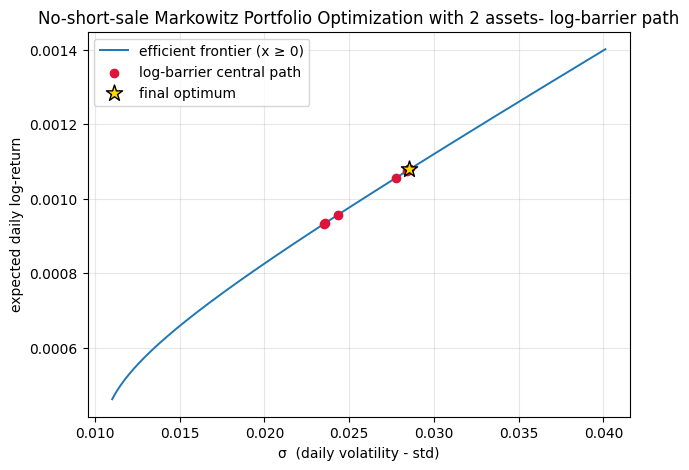

Optimal no-short portfolio:
  weight SPX  = 0.3432
  weight TSLA = 0.6568
  exp-return  = 0.00108  (per day)
  stdev       = 0.0286 (per day)


In [41]:
# trace central path
theta_list, x_list = [], []
x1_curr = 0.5     # warm start
for k in range(K+1):
    theta_k = theta_0 * (0.1**k)
    x1_curr = newton_one_theta(x1_curr, theta_k)
    theta_list.append(theta_k)
    x_list.append(np.array([x1_curr, 1-x1_curr]))

# efficient fronteir
grid = np.linspace(0,1,401)
risks = np.sqrt([np.array([g,1-g]) @ Sigma @ np.array([g,1-g]) for g in grid])
rets  = [mu @ np.array([g,1-g]) for g in grid]

#plotting
risks_c = np.sqrt([x @ Sigma @ x for x in x_list])
rets_c  = [mu @ x for x in x_list]

plt.figure(figsize=(7,5))
plt.plot(risks, rets, lw=1.4, label='efficient frontier (x ≥ 0)')
plt.scatter(risks_c, rets_c, c='crimson', zorder=3, label='log-barrier central path')
plt.scatter(risks_c[-1], rets_c[-1],
            marker='*', s=150,        # bigger star
            c='gold', edgecolors='black',
            zorder=6,                 # higher than dots and line
            label='final optimum')
plt.xlabel('σ  (daily volatility - std)')
plt.ylabel('expected daily log-return')
plt.title('No-short-sale Markowitz Portfolio Optimization with 2 assets- log-barrier path')
plt.legend(); plt.grid(alpha=.3); plt.show()

# report portfolio result
x_opt  = x_list[-1]
risk   = risks_c[-1]
ret    = rets_c[-1]
print(f"Optimal no-short portfolio:")
print(f"  weight SPX  = {x_opt[0]:.4f}")
print(f"  weight TSLA = {x_opt[1]:.4f}")
print(f"  exp-return  = {ret:.5f}  (per day)")
print(f"  stdev       = {risk:.4f} (per day)")